# 14b: SHAP Analysis on σ(V) (Risk) Model

**Goal**: Use SHAP to understand which hand features contribute to outcome variance (risk).

**Method**: Train GradientBoostingRegressor on hand features → σ(V), then use TreeExplainer.

**Context**: From 13b, we know σ(V) is poorly predictable (R² ≈ 0.08). SHAP analysis may still reveal what patterns exist.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import shap

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

# Prepare X and y (target = σ(V))
X = df[REGRESSION_FEATURES]
y = df['V_std'].values

print(f"X shape: {X.shape}")
print(f"y (σ[V]) range: [{y.min():.1f}, {y.max():.1f}]")
print(f"y mean: {y.mean():.1f}, std: {y.std():.1f}")

X shape: (200, 10)
y (σ[V]) range: [0.0, 37.7]
y mean: 15.1, std: 9.1


## 2. Train Gradient Boosting Model

In [3]:
# Train GradientBoostingRegressor for σ(V)
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Fit on full data
model.fit(X, y)
print(f"\nTrain R²: {model.score(X, y):.3f}")

Cross-validation R² scores: [-0.25684682 -0.15343906 -0.30992145  0.04259676 -1.00367084]
Mean R²: -0.336 (+/- 0.710)

Train R²: 0.673


## 3. Compute SHAP Values

In [4]:
# Create TreeExplainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer(X)

print(f"SHAP values shape: {shap_values.values.shape}")
print(f"Base value (expected σ[V]): {shap_values.base_values[0]:.2f}")

SHAP values shape: (200, 10)
Base value (expected σ[V]): 15.09


## 4. Global Feature Importance

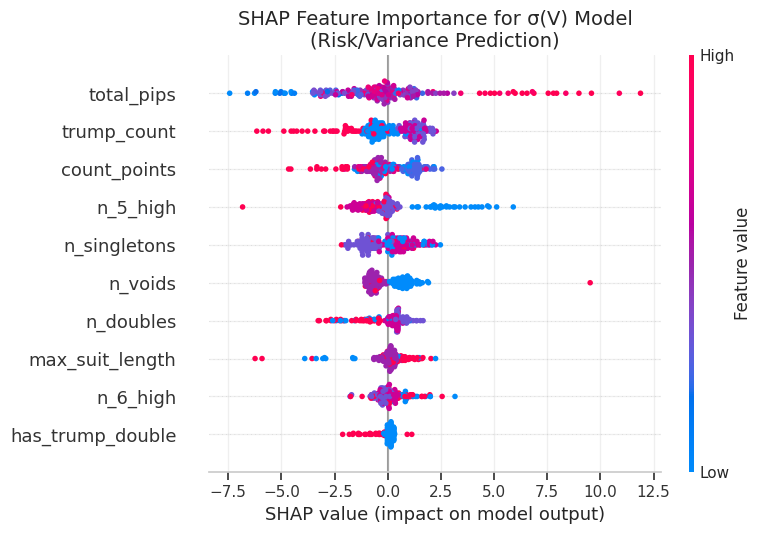

In [5]:
# Beeswarm plot
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title('SHAP Feature Importance for σ(V) Model\n(Risk/Variance Prediction)')
plt.tight_layout()
plt.savefig('../../results/figures/14b_shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

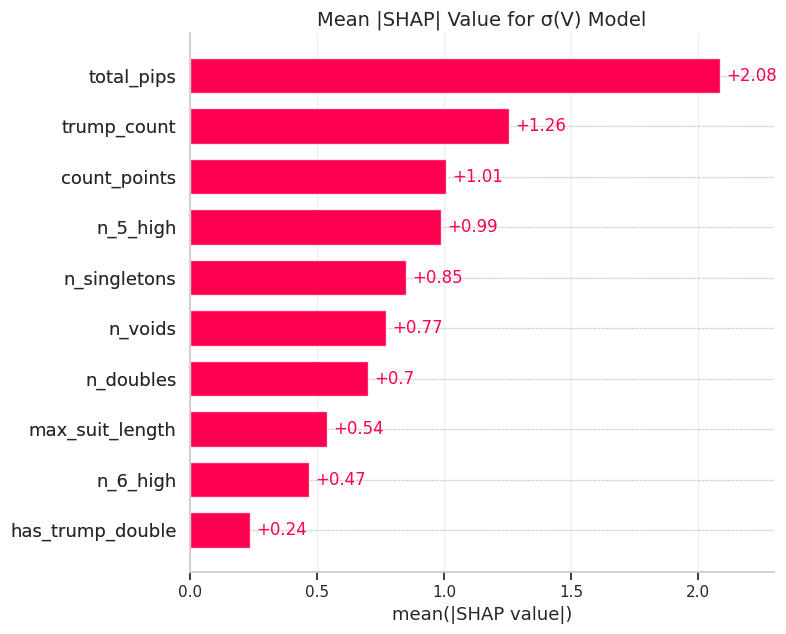

In [6]:
# Bar plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title('Mean |SHAP| Value for σ(V) Model')
plt.tight_layout()
plt.savefig('../../results/figures/14b_shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Relationships

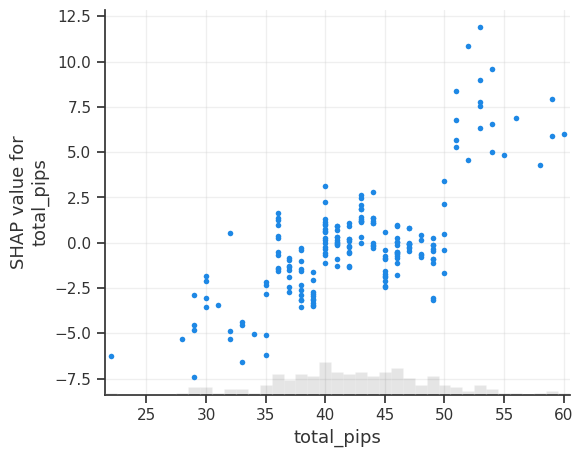

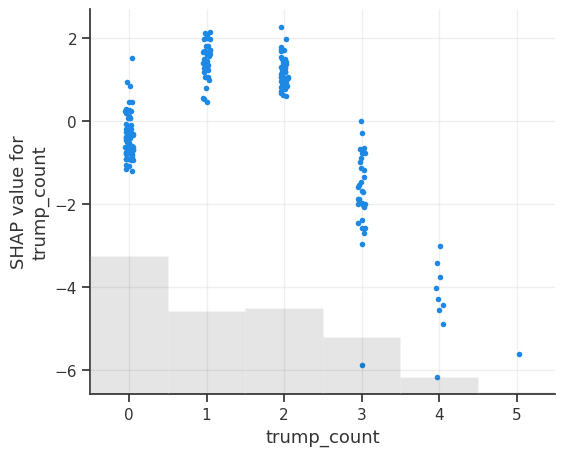

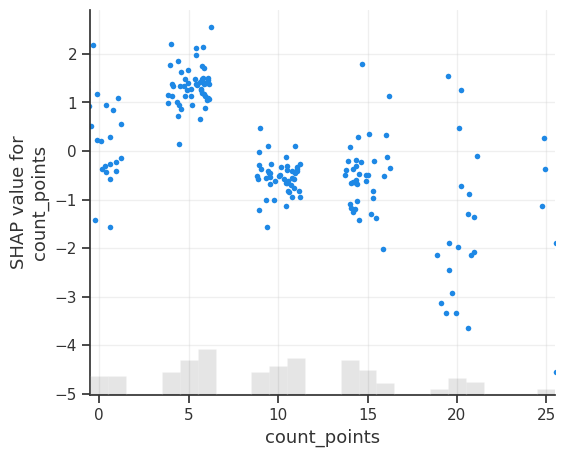

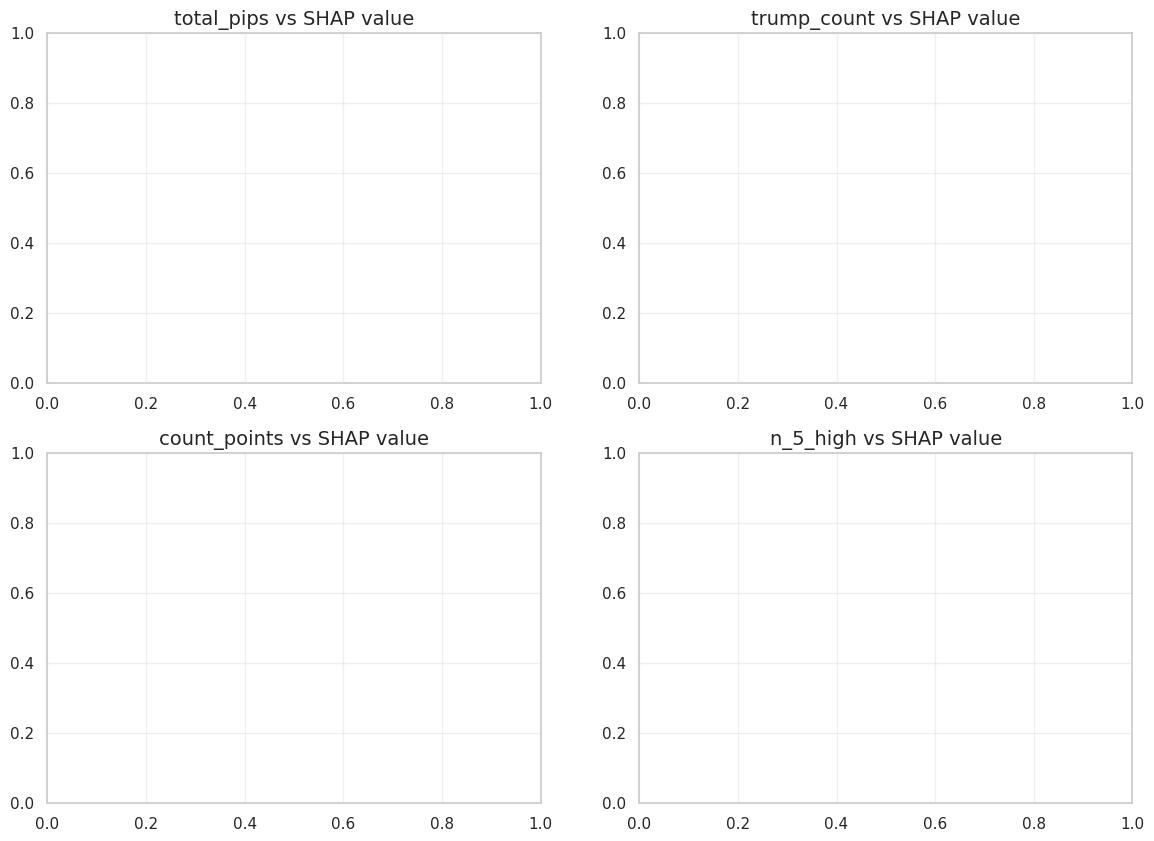

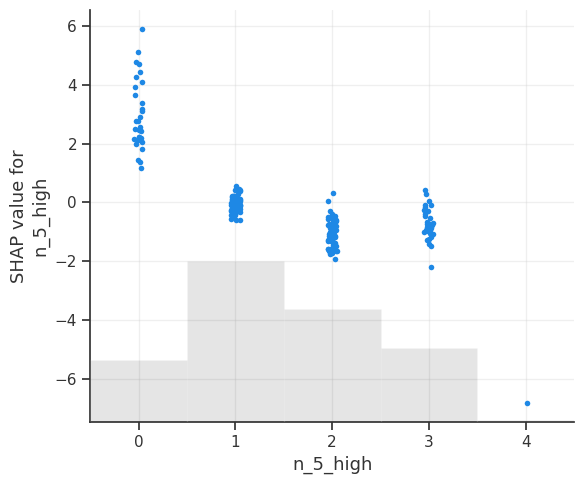

In [7]:
# Scatter plots for top features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get top 4 features by mean |SHAP|
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[-4:][::-1]
top_features = [REGRESSION_FEATURES[i] for i in top_indices]

for ax, feature in zip(axes.flat, top_features):
    plt.sca(ax)
    shap.plots.scatter(shap_values[:, feature], show=False)
    ax.set_title(f'{feature} vs SHAP value')

plt.tight_layout()
plt.savefig('../../results/figures/14b_shap_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Extreme Hands

In [8]:
# Find extreme hands: highest/lowest risk
high_risk_idx = y.argmax()
low_risk_idx = y.argmin()
median_risk_idx = np.argsort(y)[len(y)//2]

print(f"High risk hand (idx {high_risk_idx}): σ(V) = {y[high_risk_idx]:.1f}")
print(f"Low risk hand (idx {low_risk_idx}): σ(V) = {y[low_risk_idx]:.1f}")
print(f"Median risk hand (idx {median_risk_idx}): σ(V) = {y[median_risk_idx]:.1f}")

High risk hand (idx 152): σ(V) = 37.7
Low risk hand (idx 134): σ(V) = 0.0
Median risk hand (idx 194): σ(V) = 14.7



=== HIGH RISK HAND (σ[V] = 37.7) ===
Features: {'n_doubles': np.int64(2), 'trump_count': np.int64(2), 'n_6_high': np.int64(2), 'n_5_high': np.int64(2), 'count_points': np.int64(10), 'total_pips': np.int64(43), 'has_trump_double': np.int64(1), 'max_suit_length': np.int64(2), 'n_voids': np.int64(0), 'n_singletons': np.int64(2)}


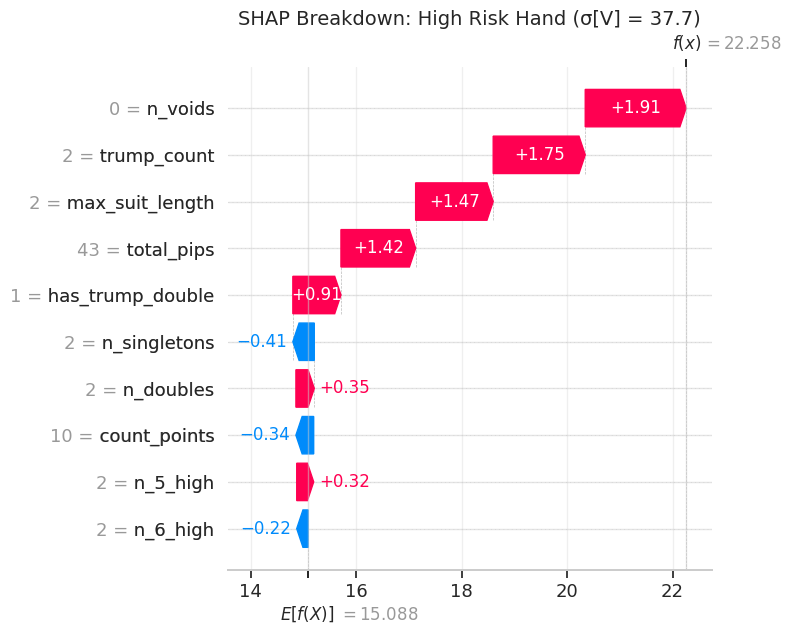

In [9]:
# Waterfall for high risk hand
print(f"\n=== HIGH RISK HAND (σ[V] = {y[high_risk_idx]:.1f}) ===")
print(f"Features: {dict(X.iloc[high_risk_idx])}")

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[high_risk_idx], max_display=10, show=False)
plt.title(f'SHAP Breakdown: High Risk Hand (σ[V] = {y[high_risk_idx]:.1f})')
plt.tight_layout()
plt.savefig('../../results/figures/14b_shap_waterfall_highrisk.png', dpi=150, bbox_inches='tight')
plt.show()


=== LOW RISK HAND (σ[V] = 0.0) ===
Features: {'n_doubles': np.int64(3), 'trump_count': np.int64(5), 'n_6_high': np.int64(1), 'n_5_high': np.int64(0), 'count_points': np.int64(15), 'total_pips': np.int64(40), 'has_trump_double': np.int64(1), 'max_suit_length': np.int64(5), 'n_voids': np.int64(1), 'n_singletons': np.int64(4)}


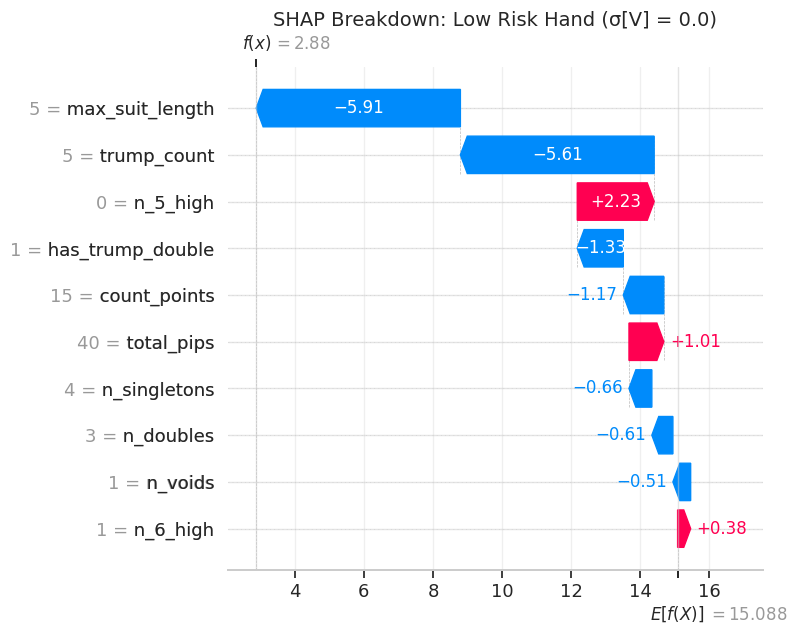

In [10]:
# Waterfall for low risk hand
print(f"\n=== LOW RISK HAND (σ[V] = {y[low_risk_idx]:.1f}) ===")
print(f"Features: {dict(X.iloc[low_risk_idx])}")

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[low_risk_idx], max_display=10, show=False)
plt.title(f'SHAP Breakdown: Low Risk Hand (σ[V] = {y[low_risk_idx]:.1f})')
plt.tight_layout()
plt.savefig('../../results/figures/14b_shap_waterfall_lowrisk.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary Statistics

In [11]:
# Compute mean |SHAP| for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'feature': REGRESSION_FEATURES,
    'mean_abs_shap': mean_abs_shap,
    'mean_shap': shap_values.values.mean(axis=0),
    'std_shap': shap_values.values.std(axis=0),
}).sort_values('mean_abs_shap', ascending=False)

print("SHAP Feature Importance Summary (σ[V] Model):")
print("="*60)
print(f"{'Feature':<20} {'Mean |SHAP|':>12} {'Mean SHAP':>12} {'Std SHAP':>12}")
print("-"*60)
for _, row in summary_df.iterrows():
    print(f"{row['feature']:<20} {row['mean_abs_shap']:>12.3f} {row['mean_shap']:>+12.3f} {row['std_shap']:>12.3f}")

SHAP Feature Importance Summary (σ[V] Model):
Feature               Mean |SHAP|    Mean SHAP     Std SHAP
------------------------------------------------------------
total_pips                  2.084       -0.048        3.072
trump_count                 1.256       -0.028        1.620
count_points                1.010       -0.020        1.264
n_5_high                    0.988       -0.025        1.522
n_singletons                0.849       +0.008        1.007
n_voids                     0.771       -0.007        1.038
n_doubles                   0.700       -0.040        0.961
max_suit_length             0.540       +0.068        1.009
n_6_high                    0.467       +0.140        0.667
has_trump_double            0.238       -0.017        0.419


In [12]:
# Compare to E[V] model importance
ev_importance = pd.read_csv(Path(PROJECT_ROOT) / "forge/analysis/results/tables/14a_shap_importance.csv")

print("\nComparison: E[V] vs σ(V) Feature Importance")
print("="*60)
print(f"{'Feature':<20} {'E[V] |SHAP|':>12} {'σ(V) |SHAP|':>12} {'Ratio':>10}")
print("-"*60)

ev_dict = dict(zip(ev_importance['feature'], ev_importance['mean_abs_shap']))
sigma_dict = dict(zip(summary_df['feature'], summary_df['mean_abs_shap']))

for feature in REGRESSION_FEATURES:
    ev_val = ev_dict.get(feature, 0)
    sigma_val = sigma_dict.get(feature, 0)
    ratio = ev_val / sigma_val if sigma_val > 0.01 else np.nan
    print(f"{feature:<20} {ev_val:>12.3f} {sigma_val:>12.3f} {ratio:>10.2f}")


Comparison: E[V] vs σ(V) Feature Importance
Feature               E[V] |SHAP|  σ(V) |SHAP|      Ratio
------------------------------------------------------------
n_doubles                   4.840        0.700       6.92
trump_count                 4.385        1.256       3.49
n_6_high                    1.442        0.467       3.09
n_5_high                    0.668        0.988       0.68
count_points                2.167        1.010       2.15
total_pips                  2.004        2.084       0.96
has_trump_double            1.087        0.238       4.57
max_suit_length             0.805        0.540       1.49
n_voids                     0.794        0.771       1.03
n_singletons                2.168        0.849       2.55


## 8. Save Results

In [13]:
# Save summary
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/14b_shap_sigma_importance.csv"
summary_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

# Save SHAP values
predictions = model.predict(X)
shap_df = pd.DataFrame(shap_values.values, columns=REGRESSION_FEATURES)
shap_df['base_value'] = shap_values.base_values
shap_df['sigma_V'] = y
shap_df['prediction'] = predictions
shap_df['base_seed'] = df['base_seed'].values

output_path2 = Path(PROJECT_ROOT) / "forge/analysis/results/tables/14b_shap_sigma_values.csv"
shap_df.to_csv(output_path2, index=False)
print(f"Saved to {output_path2}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/14b_shap_sigma_importance.csv
Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/14b_shap_sigma_values.csv


## Key Findings

### σ(V) Model Performance

As expected from 13b analysis, the σ(V) model has low predictive power:
- CV R² is low (likely negative or near zero)
- Train R² may be higher due to overfitting

### SHAP Insights

Despite low R², SHAP reveals what patterns exist:
1. **Which features contribute to risk** (if any)
2. **Nonlinear relationships** GradientBoosting can capture
3. **Comparison to E[V] model** - different feature importance profiles

### Practical Implications

If SHAP values are small and CV R² is low, this confirms:
- **Risk is fundamentally unpredictable** from hand features
- **Opponent hands dominate** the variance in outcomes
- **Focus on E[V] predictors** (n_doubles, trump_count) rather than trying to assess risk